# Directed Configuration Model Simulation

In [5]:
# Importing libraries

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

We consider simulating the directed configuration model. Firstly we describe the procedure for sampling the degrees. Suppose $(D^-, D^+)$ a $\mathbb N \times \mathbb N$ valued random variable

1. Sample a sequence $(D^-_1, D^+_1), \ldots, (D^-_n, D^+_n)$ of i.i.d. copies of $(D^-, D^+)$
2. Compute
$$ \Delta_n = \sum_{i=1}^n (D^-_i - D^+_i) $$
3. Repeat steps 1 and 2 until
$$ \lvert \Delta_n \rvert \leq n^{1 - \kappa + \delta}$$
4. Random sample indices $\{i_1, i_2, \ldots, i_{\lvert \Delta_n \rvert} \}$ without replacement
5. If $\Delta_n > 0$ then increment $D^+_{i_j}$ by 1 for $j = 1, \ldots, \lvert \Delta_n \rvert$, otherwise increment by $D^-_{i_j}$ for $j = 1, \ldots, \lvert \Delta_n \rvert$

In [6]:
def sample_degree_sequence(in_out_degrees, n, kappa = 1/2, delta = 1/10, require_graphical = False):
    """
    Given a sampler for i.i.d. in and out degrees, this generates a degree sequence of length n
    such that the total in and out degree is equal.
    
    Parameters:
    in_out_degrees (function): A function which takes n and returns a length n in-degree array
                               and a length n out-degree array 
    (int): The length of the degree sequence to sample    
    kappa (float): A constant relating to how many moments the degree distribution has
    delta (float): A tolerance parameter
    require_graphical (boolean): If true then the sequence is repeatedly sampled until it is graphical
    
    Returns:
    in_degrees (numpy array): A in-degree array of length n
    out_degrees: A out-degree array of length n
    """
    
    repeat_till_graphical = True
    
    while repeat_till_graphical:
    
        almost_balanced = False

        while not almost_balanced:
            in_degrees, out_degrees = in_out_degrees(n)

            degree_difference = np.sum(in_degrees - out_degrees)

            almost_balanced = (np.abs(degree_difference) <= np.power(n, 1 - kappa + delta))

        fill_indices = np.random.choice(n, np.abs(degree_difference), replace=False)

        for i in fill_indices:
            if degree_difference >= 0:
                out_degrees[i] += 1
            else:
                in_degrees[i] += 1
                
        repeat_till_graphical = require_graphical and not nx.is_digraphical(in_degrees, out_degrees)
            
    return in_degrees, out_degrees

The networkX package provides the function for generating the directed configuration model given a degree sequence. This is obtained by uniformly pairing off the in and out half edges. There are then two approaches to getting a simple graph. The first is the repeated DCM. In this method we just repeat the procedure until the resulting graph is simple. Mathematically this has the effect of conditioning that the pairing gives a simple graph.

Not all degree sequences can generate a simple graph though, we call the ones that do graphical. A necessary and sufficient condition for a degree sequence to be graphical is

1. $\sum_{i=1}^n D^-_i = \sum_{i=1}^n D^+_i$,
2. and $\sum_{i=1}^n \min\{D^+_i, \lvert A - \{v_i\} \rvert\} \geq \sum_{v_i \in A} D^-_i$ for any $A \subset V$.

The second approach is to just erase all loops and collapse all multi-edges. This will alter the degree sequence but is algorithmically very efficient.

In [5]:
def repeated_dcm(degree_sequence):
    """
    Generates a multigraph by repeating the repeatedly sampling a DCM until the graph is simple
    """
    
    # checking if sequence is graphical
    if not nx.is_digraphical(in_degrees, out_degrees):
        raise InputError("Running repeated DCM with a non-graphical sequence")
    
    is_simple = False
    
    while not is_simple:
        G =  nx.directed_configuration_model(in_degrees, out_degrees)
        is_simple
        
    return G

def erased_dcm(degree_sequence):
    """
    Generates a multigraph by sampling a DCM and collapsing multiedges and removing loops
    """
    
    G = nx.directed_configuration_model(in_degrees, out_degrees)
    
    G = nx.DiGraph(D) # collapsing multiedges
    G.removed_edges_from(nx.selfloop_edges(G)) # removing loops
    
    return G

We define three ways of sampling the in and out degrees.

In the first method the in and out degrees are independent $\text{Po}(1)$ random variables

In the second method the in and out degrees are positively correlated. We sample $X \sim $ and then take $D^- \sim$ and $D^+ \sim $.

In the third method, the in and out degrees are negatively correlated.

[7, 10, 1, 1, 9, 17, 8, 9, 1, 7, 7, 17, 5, 30, 4, 18, 5, 9, 1, 38, 9, 1, 32, 1, 12, 20, 47, 25, 1, 5, 13, 3, 12, 5, 5, 1, 2, 1, 1, 32, 21, 8, 2, 1, 12, 8, 25, 42, 12, 33, 9, 27, 18, 5, 9, 7, 1, 12, 10, 51, 5, 20, 1, 8, 2, 5, 35, 53, 1, 3, 4, 19, 3, 5, 3, 9, 31, 97, 9, 13, 6, 10, 1, 10, 13, 6, 1, 16, 27, 28, 6, 12, 6, 6, 71, 19, 23, 3, 6, 14]
[4, 2, 9, 6, 9, 8, 2, 3, 10, 10, 1, 5, 6, 9, 2, 5, 3, 1, 8, 1, 4, 19, 11, 12, 3, 2, 10, 5, 2, 1, 11, 4, 1, 14, 10, 6, 6, 31, 3, 35, 1, 1, 1, 1, 5, 2, 17, 8, 16, 3, 6, 2, 25, 4, 7, 4, 4, 5, 5, 3, 13, 1, 23, 6, 18, 1, 9, 3, 5, 1, 11, 4, 6, 4, 5, 1, 7, 1, 10, 9, 7, 10, 24, 4, 3, 2, 3, 1, 4, 4, 1, 1, 4, 1, 1, 5, 3, 3, 5, 1]
[31, 5, 3, 5, 3, 15, 13, 6, 3, 6, 14, 16, 11, 27, 20, 1, 1, 3, 1, 2, 9, 7, 1, 3, 18, 7, 8, 4, 1, 14, 6, 41, 4, 8, 5, 3, 20, 21, 27, 7, 7, 13, 2, 7, 29, 6, 8, 16, 21, 23, 48, 19, 7, 16, 2, 6, 12, 1, 16, 14, 8, 5, 1, 8, 5, 4, 6, 3, 3, 4, 9, 1, 5, 3, 1, 9, 14, 55, 1, 17, 8, 29, 1, 1, 39, 4, 1, 5, 1, 1, 6, 8, 16, 11, 2, 10, 1, 9, 16, 18

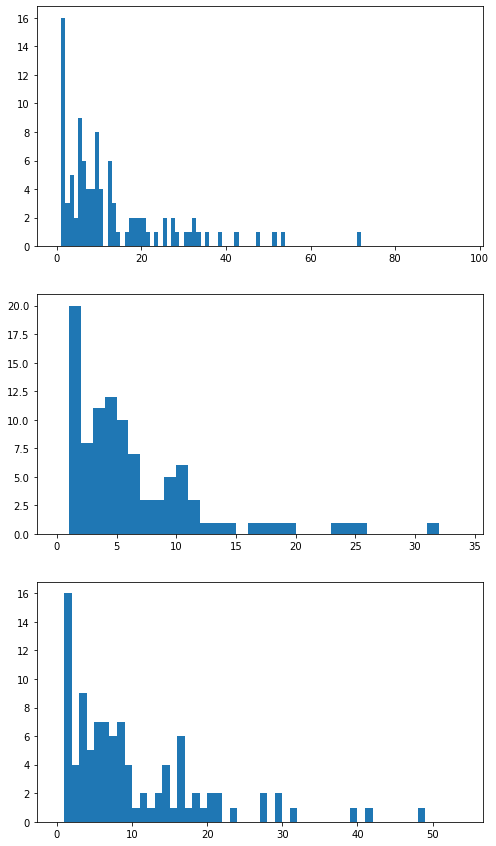

In [79]:
def poisson_indep(n):
    rate = 1
    return np.random.poisson(rate, n), np.random.poisson(rate, n)

def poisson_positive_corr(n):
    rate = np.random.exponential(1/2, n)
    return np.random.poisson(rate), np.random.poisson(rate)

def poisson_negative_corr(n):
    m = 3
    c = np.random.random(n) * m
    
    return np.random.poisson(c), np.random.poisson(m-c)
    
def directed_gnp(n):
    p = 1/n
    forward_graph = nx.fast_gnp_random_graph(n, p)
    backward_graph = nx.fast_gnp_random_graph(n, p)
    
    G = nx.DiGraph()
    
    for (v, w) in forward_graph.edges:
        [x, y] = sorted([v, w])
        G.add_edge(x, y)
        
    for (v, w) in backward_graph.edges:
        [y, x] = sorted([v, w])
        G.add_edge(x, y)
        
    return G

# parameters

tries = 100
n = 1000
degree_generator_list = [poisson_indep, poisson_positive_corr, poisson_negative_corr]

# sampling the configuration mode

fig, [ax1, ax2, ax3] = plt.subplots(3, 1, figsize=(8, 15))

for degree_generator, ax in zip(degree_generator_list, [ax1, ax2, ax3]):
    largest_component_sizes = []

    for _ in range(tries):
        in_degrees, out_degrees = sample_degree_sequence(degree_generator, n)
        G = nx.directed_configuration_model(in_degrees, out_degrees)
        #G = directed_gnp(n)

        # finding the largest scc

        scc_list = nx.strongly_connected_components(G)
        largest_component_sizes.append(max(len(component) for component in scc_list))
    
    ax.hist(largest_component_sizes, bins=range(max(largest_component_sizes)))

Next, we plot a histogram for the degrees of the largest scc of m samples of the DCM.

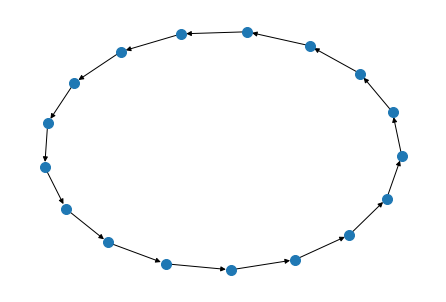

In [90]:
n = 1000000

degree_generator = poisson_positive_corr

in_degrees, out_degrees = sample_degree_sequence(degree_generator, n)
G = nx.directed_configuration_model(in_degrees, out_degrees)

# finding the largest scc

scc_list = nx.strongly_connected_components(G)
vertices = max(scc_list, key=len)

nx.draw_kamada_kawai(G.subgraph(vertices), node_size=100)